# Method 8 - Best Ideas Low Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[best_ideas['size_pct'] < (1 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

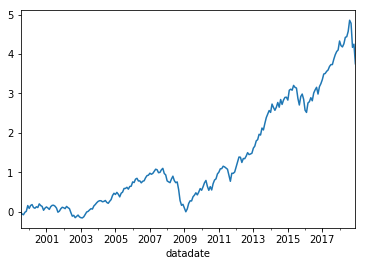

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.152286
2000-12-31   -0.055863
2001-12-31    0.019411
2002-12-31   -0.220145
2003-12-31    0.415501
2004-12-31    0.196218
2005-12-31    0.122478
2006-12-31    0.170411
2007-12-31    0.003327
2008-12-31   -0.386751
2009-12-31    0.337918
2010-12-31    0.234356
2011-12-31    0.024809
2012-12-31    0.238296
2013-12-31    0.436750
2014-12-31    0.094587
2015-12-31   -0.013719
2016-12-31    0.103144
2017-12-31    0.201617
2018-12-31   -0.068889
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     718.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.66e-128
Time:                        07:10:28   Log-Likelihood:                 693.70
No. Observations:                 234   AIC:                            -1377.
Df Residuals:                     229   BIC:                            -1360.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.669      0.008       0.001       0.004
mktrf          0.9893      0.024     42.040      0.000       0.943       1.036
me             0.2673      0.027      9.765      0.000       0.213       0.321
ia             0.0186      0.042      0.446      0.656      -0.063       0.101
roe            0.1149      0.036      3.226      0.001       0.045       0.185
==============================================================================
Omnibus:                       38.016   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.498
Skew:                           0.527   Prob(JB):                     3.14e-36
Kurtosis:                       6.957   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     862.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          9.47e-137
Time:                        07:10:28   Log-Likelihood:                 693.70
No. Observations:                 234   AIC:                            -1377.
Df Residuals:                     229   BIC:                            -1360.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      3.276      0.001       0.001       0.004
mktrf          0.9893      0.029     33.769      0.000       0.932       1.047
me             0.2673      0.046      5.838      0.000       0.178       0.357
ia             0.0186      0.091      0.205      0.838      -0.159       0.196
roe            0.1149      0.035      3.244      0.001       0.045       0.184
==============================================================================
Omnibus:                       38.016   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.498
Skew:                           0.527   Prob(JB):                     3.14e-36
Kurtosis:                       6.957   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     1077.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.59e-147
Time:                        07:10:29   Log-Likelihood:                 693.70
No. Observations:                 234   AIC:                            -1377.
Df Residuals:                     229   BIC:                            -1360.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      3.181      0.001       0.001       0.004
mktrf          0.9893      0.027     37.127      0.000       0.937       1.042
me             0.2673      0.039      6.807      0.000       0.190       0.344
ia             0.0186      0.092      0.202      0.840      -0.162       0.199
roe            0.1149      0.034      3.352      0.001       0.048       0.182
==============================================================================
Omnibus:                       38.016   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.498
Skew:                           0.527   Prob(JB):                     3.14e-36
Kurtosis:                       6.957   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     558.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.08e-125
Time:                        07:10:29   Log-Likelihood:                 690.98
No. Observations:                 234   AIC:                            -1370.
Df Residuals:                     228   BIC:                            -1349.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.592      0.010       0.001       0.004
mktrf          0.9774      0.024     40.885      0.000       0.930       1.025
smb            0.3111      0.032      9.862      0.000       0.249       0.373
hml            0.0494      0.037      1.328      0.186      -0.024       0.123
rmw            0.1241      0.042      2.951      0.003       0.041       0.207
cma           -0.0729      0.053     -1.363      0.174      -0.178       0.032
==============================================================================
Omnibus:                       28.189   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.684
Skew:                           0.416   Prob(JB):                     4.54e-21
Kurtosis:                       5.986   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     710.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.70e-137
Time:                        07:10:29   Log-Likelihood:                 690.98
No. Observations:                 234   AIC:                            -1370.
Df Residuals:                     228   BIC:                            -1349.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.860      0.004       0.001       0.004
mktrf          0.9774      0.024     39.981      0.000       0.930       1.025
smb            0.3111      0.035      9.001      0.000       0.243       0.379
hml            0.0494      0.061      0.803      0.422      -0.071       0.170
rmw            0.1241      0.040      3.119      0.002       0.046       0.202
cma           -0.0729      0.100     -0.729      0.466      -0.269       0.123
==============================================================================
Omnibus:                       28.189   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.684
Skew:                           0.416   Prob(JB):                     4.54e-21
Kurtosis:                       5.986   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     722.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.41e-137
Time:                        07:10:29   Log-Likelihood:                 690.98
No. Observations:                 234   AIC:                            -1370.
Df Residuals:                     228   BIC:                            -1349.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.586      0.010       0.001       0.004
mktrf          0.9774      0.024     40.027      0.000       0.930       1.025
smb            0.3111      0.029     10.714      0.000       0.254       0.368
hml            0.0494      0.065      0.762      0.446      -0.078       0.176
rmw            0.1241      0.034      3.627      0.000       0.057       0.191
cma           -0.0729      0.097     -0.750      0.453      -0.263       0.118
==============================================================================
Omnibus:                       28.189   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.684
Skew:                           0.416   Prob(JB):                     4.54e-21
Kurtosis:                       5.986   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     713.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.32e-128
Time:                        07:10:29   Log-Likelihood:                 693.00
No. Observations:                 234   AIC:                            -1376.
Df Residuals:                     229   BIC:                            -1359.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.727      0.007       0.001       0.004
mktrf          1.0043      0.022     46.212      0.000       0.961       1.047
smb            0.2019      0.027      7.444      0.000       0.148       0.255
hml            0.1306      0.027      4.847      0.000       0.078       0.184
umd            0.0928      0.018      5.251      0.000       0.058       0.128
==============================================================================
Omnibus:                       15.722   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.601
Skew:                           0.070   Prob(JB):                     1.25e-10
Kurtosis:                       5.158   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     831.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.81e-135
Time:                        07:10:29   Log-Likelihood:                 693.00
No. Observations:                 234   AIC:                            -1376.
Df Residuals:                     229   BIC:                            -1359.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.779      0.005       0.001       0.004
mktrf          1.0043      0.028     36.484      0.000       0.950       1.058
smb            0.2019      0.046      4.409      0.000       0.112       0.292
hml            0.1306      0.057      2.284      0.022       0.019       0.243
umd            0.0928      0.029      3.161      0.002       0.035       0.150
==============================================================================
Omnibus:                       15.722   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.601
Skew:                           0.070   Prob(JB):                     1.25e-10
Kurtosis:                       5.158   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     1012.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.05e-144
Time:                        07:10:29   Log-Likelihood:                 693.00
No. Observations:                 234   AIC:                            -1376.
Df Residuals:                     229   BIC:                            -1359.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.730      0.006       0.001       0.004
mktrf          1.0043      0.024     41.623      0.000       0.957       1.052
smb            0.2019      0.044      4.576      0.000       0.115       0.288
hml            0.1306      0.060      2.174      0.030       0.013       0.248
umd            0.0928      0.022      4.144      0.000       0.049       0.137
==============================================================================
Omnibus:                       15.722   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.601
Skew:                           0.070   Prob(JB):                     1.25e-10
Kurtosis:                       5.158   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     321.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.06e-61
Time:                        07:10:29   Log-Likelihood:                 339.13
No. Observations:                 120   AIC:                            -668.3
Df Residuals:                     115   BIC:                            -654.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.601      0.112      -0.001       0.005
mktrf          1.0167      0.038     26.938      0.000       0.942       1.092
me             0.2589      0.037      6.945      0.000       0.185       0.333
ia             0.0584      0.058      1.001      0.319      -0.057       0.174
roe            0.1657      0.052      3.207      0.002       0.063       0.268
==============================================================================
Omnibus:                       27.415   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.076
Skew:                           0.753   Prob(JB):                     2.04e-19
Kurtosis:                       6.866   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     438.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.29e-68
Time:                        07:10:29   Log-Likelihood:                 339.13
No. Observations:                 120   AIC:                            -668.3
Df Residuals:                     115   BIC:                            -654.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.302      0.021       0.000       0.004
mktrf          1.0167      0.043     23.645      0.000       0.932       1.101
me             0.2589      0.046      5.669      0.000       0.169       0.348
ia             0.0584      0.105      0.554      0.579      -0.148       0.265
roe            0.1657      0.051      3.224      0.001       0.065       0.266
==============================================================================
Omnibus:                       27.415   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.076
Skew:                           0.753   Prob(JB):                     2.04e-19
Kurtosis:                       6.866   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     701.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.11e-80
Time:                        07:10:29   Log-Likelihood:                 339.13
No. Observations:                 120   AIC:                            -668.3
Df Residuals:                     115   BIC:                            -654.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.096      0.036       0.000       0.004
mktrf          1.0167      0.040     25.201      0.000       0.938       1.096
me             0.2589      0.038      6.894      0.000       0.185       0.333
ia             0.0584      0.100      0.586      0.558      -0.137       0.254
roe            0.1657      0.049      3.369      0.001       0.069       0.262
==============================================================================
Omnibus:                       27.415   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.076
Skew:                           0.753   Prob(JB):                     2.04e-19
Kurtosis:                       6.866   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     230.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.94e-58
Time:                        07:10:29   Log-Likelihood:                 333.68
No. Observations:                 120   AIC:                            -655.4
Df Residuals:                     114   BIC:                            -638.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.002      1.685      0.095      -0.000       0.006
mktrf          1.0065      0.042     24.061      0.000       0.924       1.089
smb            0.3225      0.047      6.807      0.000       0.229       0.416
hml            0.0358      0.058      0.617      0.539      -0.079       0.151
rmw            0.1727      0.068      2.523      0.013       0.037       0.308
cma           -0.0134      0.075     -0.179      0.859      -0.162       0.135
==============================================================================
Omnibus:                       13.967   Durbin-Watson:                   2.207
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               26.682
Skew:                           0.464   Prob(JB):                     1.61e-06
Kurtosis:                       5.115   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     253.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.89e-60
Time:                        07:10:29   Log-Likelihood:                 333.68
No. Observations:                 120   AIC:                            -655.4
Df Residuals:                     114   BIC:                            -638.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.938      0.053   -2.88e-05       0.005
mktrf          1.0065      0.048     21.039      0.000       0.913       1.100
smb            0.3225      0.047      6.907      0.000       0.231       0.414
hml            0.0358      0.101      0.354      0.723      -0.162       0.234
rmw            0.1727      0.081      2.141      0.032       0.015       0.331
cma           -0.0134      0.121     -0.111      0.911      -0.250       0.223
==============================================================================
Omnibus:                       13.967   Durbin-Watson:                   2.207
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               26.682
Skew:                           0.464   Prob(JB):                     1.61e-06
Kurtosis:                       5.115   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     276.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.05e-62
Time:                        07:10:29   Log-Likelihood:                 333.68
No. Observations:                 120   AIC:                            -655.4
Df Residuals:                     114   BIC:                            -638.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.762      0.078      -0.000       0.005
mktrf          1.0065      0.051     19.894      0.000       0.907       1.106
smb            0.3225      0.039      8.231      0.000       0.246       0.399
hml            0.0358      0.112      0.320      0.749      -0.184       0.255
rmw            0.1727      0.084      2.053      0.040       0.008       0.338
cma           -0.0134      0.119     -0.113      0.910      -0.246       0.219
==============================================================================
Omnibus:                       13.967   Durbin-Watson:                   2.207
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               26.682
Skew:                           0.464   Prob(JB):                     1.61e-06
Kurtosis:                       5.115   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     302.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.23e-60
Time:                        07:10:29   Log-Likelihood:                 335.75
No. Observations:                 120   AIC:                            -661.5
Df Residuals:                     115   BIC:                            -647.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      2.405      0.018       0.001       0.006
mktrf          1.0217      0.034     29.873      0.000       0.954       1.089
smb            0.1812      0.039      4.654      0.000       0.104       0.258
hml            0.1712      0.039      4.390      0.000       0.094       0.248
umd            0.0995      0.024      4.139      0.000       0.052       0.147
==============================================================================
Omnibus:                        5.300   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                7.569
Skew:                           0.092   Prob(JB):                       0.0227
Kurtosis:                       4.217   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     353.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.25e-63
Time:                        07:10:29   Log-Likelihood:                 335.75
No. Observations:                 120   AIC:                            -661.5
Df Residuals:                     115   BIC:                            -647.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.170      0.002       0.001       0.005
mktrf          1.0217      0.042     24.443      0.000       0.940       1.104
smb            0.1812      0.050      3.601      0.000       0.083       0.280
hml            0.1712      0.066      2.613      0.009       0.043       0.300
umd            0.0995      0.035      2.833      0.005       0.031       0.168
==============================================================================
Omnibus:                        5.300   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                7.569
Skew:                           0.092   Prob(JB):                       0.0227
Kurtosis:                       4.217   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     442.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.41e-69
Time:                        07:10:29   Log-Likelihood:                 335.75
No. Observations:                 120   AIC:                            -661.5
Df Residuals:                     115   BIC:                            -647.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.230      0.001       0.001       0.005
mktrf          1.0217      0.036     28.456      0.000       0.951       1.092
smb            0.1812      0.045      4.028      0.000       0.093       0.269
hml            0.1712      0.064      2.661      0.008       0.045       0.297
umd            0.0995      0.026      3.887      0.000       0.049       0.150
==============================================================================
Omnibus:                        5.300   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                7.569
Skew:                           0.092   Prob(JB):                       0.0227
Kurtosis:                       4.217   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     534.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.26e-70
Time:                        07:10:30   Log-Likelihood:                 375.73
No. Observations:                 114   AIC:                            -741.5
Df Residuals:                     109   BIC:                            -727.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.004      0.003       0.001       0.005
mktrf          0.9648      0.027     35.806      0.000       0.911       1.018
me             0.2928      0.042      7.039      0.000       0.210       0.375
ia            -0.1627      0.058     -2.819      0.006      -0.277      -0.048
roe           -0.0770      0.051     -1.519      0.132      -0.178       0.023
==============================================================================
Omnibus:                        2.062   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.357   Jarque-Bera (JB):                1.562
Skew:                           0.156   Prob(JB):                        0.458
Kurtosis:                       3.481   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     801.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.86e-80
Time:                        07:10:30   Log-Likelihood:                 375.73
No. Observations:                 114   AIC:                            -741.5
Df Residuals:                     109   BIC:                            -727.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.652      0.008       0.001       0.005
mktrf          0.9648      0.019     50.353      0.000       0.927       1.002
me             0.2928      0.033      8.931      0.000       0.229       0.357
ia            -0.1627      0.078     -2.087      0.037      -0.315      -0.010
roe           -0.0770      0.048     -1.617      0.106      -0.170       0.016
==============================================================================
Omnibus:                        2.062   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.357   Jarque-Bera (JB):                1.562
Skew:                           0.156   Prob(JB):                        0.458
Kurtosis:                       3.481   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     1306.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.45e-91
Time:                        07:10:30   Log-Likelihood:                 375.73
No. Observations:                 114   AIC:                            -741.5
Df Residuals:                     109   BIC:                            -727.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.519      0.012       0.001       0.005
mktrf          0.9648      0.014     68.498      0.000       0.937       0.992
me             0.2928      0.033      8.950      0.000       0.229       0.357
ia            -0.1627      0.086     -1.894      0.058      -0.331       0.006
roe           -0.0770      0.040     -1.916      0.055      -0.156       0.002
==============================================================================
Omnibus:                        2.062   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.357   Jarque-Bera (JB):                1.562
Skew:                           0.156   Prob(JB):                        0.458
Kurtosis:                       3.481   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     558.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.07e-75
Time:                        07:10:30   Log-Likelihood:                 390.76
No. Observations:                 114   AIC:                            -769.5
Df Residuals:                     108   BIC:                            -753.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.391      0.019       0.000       0.004
mktrf          0.9736      0.023     43.026      0.000       0.929       1.018
smb            0.2717      0.037      7.396      0.000       0.199       0.344
hml           -0.0343      0.047     -0.732      0.466      -0.127       0.059
rmw           -0.1613      0.057     -2.811      0.006      -0.275      -0.048
cma           -0.1939      0.073     -2.662      0.009      -0.338      -0.050
==============================================================================
Omnibus:                        4.056   Durbin-Watson:                   1.709
Prob(Omnibus):                  0.132   Jarque-Bera (JB):                3.436
Skew:                           0.365   Prob(JB):                        0.179
Kurtosis:                       3.438   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     990.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.76e-88
Time:                        07:10:30   Log-Likelihood:                 390.76
No. Observations:                 114   AIC:                            -769.5
Df Residuals:                     108   BIC:                            -753.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.161      0.031       0.000       0.004
mktrf          0.9736      0.016     61.178      0.000       0.942       1.005
smb            0.2717      0.032      8.574      0.000       0.210       0.334
hml           -0.0343      0.049     -0.704      0.482      -0.130       0.061
rmw           -0.1613      0.043     -3.739      0.000      -0.246      -0.077
cma           -0.1939      0.084     -2.303      0.021      -0.359      -0.029
==============================================================================
Omnibus:                        4.056   Durbin-Watson:                   1.709
Prob(Omnibus):                  0.132   Jarque-Bera (JB):                3.436
Skew:                           0.365   Prob(JB):                        0.179
Kurtosis:                       3.438   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     1370.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.25e-96
Time:                        07:10:30   Log-Likelihood:                 390.76
No. Observations:                 114   AIC:                            -769.5
Df Residuals:                     108   BIC:                            -753.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.894      0.058   -6.68e-05       0.004
mktrf          0.9736      0.015     66.068      0.000       0.945       1.002
smb            0.2717      0.029      9.297      0.000       0.214       0.329
hml           -0.0343      0.043     -0.800      0.424      -0.118       0.050
rmw           -0.1613      0.043     -3.761      0.000      -0.245      -0.077
cma           -0.1939      0.074     -2.618      0.009      -0.339      -0.049
==============================================================================
Omnibus:                        4.056   Durbin-Watson:                   1.709
Prob(Omnibus):                  0.132   Jarque-Bera (JB):                3.436
Skew:                           0.365   Prob(JB):                        0.179
Kurtosis:                       3.438   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     629.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.55e-74
Time:                        07:10:30   Log-Likelihood:                 384.63
No. Observations:                 114   AIC:                            -759.3
Df Residuals:                     109   BIC:                            -745.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.301      0.196      -0.001       0.003
mktrf          0.9990      0.024     42.304      0.000       0.952       1.046
smb            0.3063      0.037      8.319      0.000       0.233       0.379
hml           -0.0433      0.038     -1.141      0.256      -0.118       0.032
umd            0.0540      0.029      1.887      0.062      -0.003       0.111
==============================================================================
Omnibus:                        1.582   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.453   Jarque-Bera (JB):                1.133
Skew:                          -0.023   Prob(JB):                        0.568
Kurtosis:                       3.486   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     1606.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.19e-96
Time:                        07:10:30   Log-Likelihood:                 384.63
No. Observations:                 114   AIC:                            -759.3
Df Residuals:                     109   BIC:                            -745.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.273      0.203      -0.001       0.003
mktrf          0.9990      0.016     64.151      0.000       0.969       1.030
smb            0.3063      0.032      9.546      0.000       0.243       0.369
hml           -0.0433      0.039     -1.109      0.267      -0.120       0.033
umd            0.0540      0.021      2.534      0.011       0.012       0.096
==============================================================================
Omnibus:                        1.582   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.453   Jarque-Bera (JB):                1.133
Skew:                          -0.023   Prob(JB):                        0.568
Kurtosis:                       3.486   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     2312.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.27e-104
Time:                        07:10:30   Log-Likelihood:                 384.63
No. Observations:                 114   AIC:                            -759.3
Df Residuals:                     109   BIC:                            -745.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.193      0.233      -0.001       0.003
mktrf          0.9990      0.013     77.782      0.000       0.974       1.024
smb            0.3063      0.032      9.609      0.000       0.244       0.369
hml           -0.0433      0.038     -1.135      0.257      -0.118       0.031
umd            0.0540      0.020      2.729      0.006       0.015       0.093
==============================================================================
Omnibus:                        1.582   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.453   Jarque-Bera (JB):                1.133
Skew:                          -0.023   Prob(JB):                        0.568
Kurtosis:                       3.486   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""